In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/data/train.csv')
df.head(10)

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1
5,0.1318,90000.0,3.48,7,0,0,2903,31,0,0,0,19548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7000,7000.0,0.0,1,7,236.47,0.854,0.0,0.0,1330.30,660,664,0
6,0.0791,60000.0,17.34,0,0,0,20399,35,0,0,0,117320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,20000,20000.0,0.0,1,18,625.90,0.369,0.0,0.0,2567.44,750,754,0
7,0.0975,79600.0,15.97,3,0,1,6481,17,0,0,0,18757,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,23800,23800.0,0.0,1,7,765.17,0.745,0.0,0.0,3006.76,680,684,0
8,0.0789,150000.0,7.36,1,0,0,15827,38,0,0,543,367504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,16000,16000.0,0.0,1,19,500.58,0.334,0.0,0.0,1286.38,665,669,0
9,0.0999,95000.0,25.78,0,1,0,17870,37,0,0,0,273776,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,24,258.10,0.764,0.0,0.0,796.59,665,669,0


In [ ]:
X = df.drop('depvar', axis=1)
y = df['depvar']

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
# 하이퍼 파라미터 튜닝
lgbm_clf = LGBMClassifier(tree_method='gpu_hist',
                                gpu_id=0,
                                seed=42)

param_grid = {'boosting_type' : ['dart'],
              'eta' : [0.05],
              'max_depth':[7],
              'min_child_weight' : [0.001, 0.002], # 0.001, 0. ... 
              'n_estimators':[348],

              'num_leaves' : [31, 40],  # better acc when the value is less than 2^(max_depth)  default== 31
              'min_child_samples' : [20, 15], # default 20,  the larger value can cause underfitting, default==0
            
             # 'gamma' : [0], #0 ~ 1
               
               'reg_alpha' : [0.7, 0.9], # 0 ~ 1 
               'reg_lambda':[0, 0.5, 0.9], # 0 ~ 1
               'is_unbalance' : [True, False]
               }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

grid_search = GridSearchCV(estimator=lgbm_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='f1_macro', 
                           error_score=0)
lgbm_clf_results=grid_search.fit(X_train, y_train)

lgbm_clf_results.best_params_

In [ ]:
# best parameter를 사용하여 prediction 수행
lgbm_clf = LGBMClassifier(boosting_type='dart',
                          eta=lgbm_clf_results.best_params_['eta'],
                          max_depth = lgbm_clf_results.best_params_['max_depth'],
                          min_child_weight=lgbm_clf_results.best_params_['min_child_weight'],
                          n_estimators = lgbm_clf_results.best_params_['n_estimators'],
                          num_leaves = lgbm_clf_results.best_params_['num_leaves'],
                          min_child_samples= lgbm_clf_results.best_params_['min_child_samples'],

                          eval_metric='logloss',
                          objective= 'binary' ,


                          reg_alpha= lgbm_clf_results.best_params_['reg_alpha'],
                          #   gamma=lgbm_clf_results.best_params_['gamma'],
                          reg_lambda=lgbm_clf_results.best_params_['reg_lambda'],
                          
                          )

lgbm_clf.fit(X_train, y_train)

y_pred_lgbm = lgbm_clf.predict(X_valid)

In [ ]:
# y_valid가 0 또는 1일 확률 출력
y_pred_prob_lgbm = lgbm_clf.predict_proba(X_valid)

print(len(y_pred_prob_lgbm))
y_pred_prob_lgbm

20000


array([[0.82835895, 0.17164105],
       [0.31040913, 0.68959087],
       [0.55654519, 0.44345481],
       ...,
       [0.66991694, 0.33008306],
       [0.78515177, 0.21484823],
       [0.3555994 , 0.6444006 ]])

In [ ]:
# y_valid가 1일 확률 출력
y_pred_prob_lgbm[:,1]

array([0.17164105, 0.68959087, 0.44345481, ..., 0.33008306, 0.21484823,
       0.6444006 ])

In [ ]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')


정확도: 0.7553
정밀도: 0.6610
재현율: 0.5313
AUC: 0.6985
F1: 0.7074


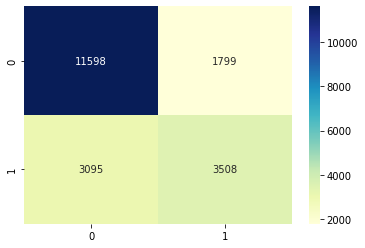

In [ ]:
# xgboost 성능 확인
get_clf_eval(y_valid, y_pred_lgbm)


정확도: 0.7457
정밀도: 0.6101
재현율: 0.6362
AUC: 0.7179
F1: 0.7155


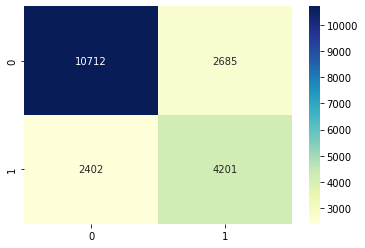

In [ ]:
# threshold 변경 및 성능 확인
get_clf_eval(y_valid, y_pred_prob_lgbm[:,1] > 0.4299)

In [ ]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/data/sample_submission.csv')
submit.head()

,ID,answer
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/data/test.csv')
submit['answer'] = (lgbm_clf.predict_proba(df_test.drop(columns=['ID']))[:,1] > 0.4299) * 1

submit.head(20)

,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,0
6,6,1
7,7,1
8,8,0
9,9,1


In [ ]:

# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/prediction20.csv', index=False)